# A script for creating Figure X of the LOVE19 ESSD Paper

- This script assumes it is located inside a subdirectory of the ESSD/Zenodo data.
- The Zenodo directory has an assumed architecture. Note that Zenodo does not allow a directory structure, so the data would need to be reorganized or the directory paths provided would need to be altered in order to run this script.
- The script demonstrates the use of the upper boundary layer elements of LOVE19: SODAR-RASS, LIDAR, FlyFOX-V.

In [1]:
# Data manipulation
import numpy as np
import xarray as xr
import pandas as pd
import pyfocs

# OS interaction
import os

# Plotting libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
import matplotlib.patches as patches

/Users/karllapo/anaconda3/lib/python3.8/abc.py:85: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#3498db", "#FFBF00", "#95a5a6", "#34495e", "#e74c3c", "#9b59b6",]
sns.set_palette(sns.color_palette(flatui))

## Directories

The below command should return the path to the LOVE19 ESSD repository `example-scripts` repository.

In [3]:
# Assumes a particular relative location between the notebook and ESSD repository.
# Additionally, the Zendodo repository was locally organized into subdirectories.
# To run the notebook you will need to point these directories to where your data
# are located.
dir_notebook = os.getcwd()
os.chdir('../..')
dir_essd = os.getcwd()
dir_essd = os.path.join(dir_essd, 'love_dts/ESSD-repository')

# Met data
dir_csat_flux = os.path.join(dir_essd, 'CSAT fluxes')
dir_csat_ts = os.path.join(dir_essd, 'CSAT 20Hz')
dir_aws = os.path.join(dir_essd, 'AWS')

# Figures
dir_print = os.path.join(dir_essd, 'figures')

# DTS data
dir_fods_cross = os.path.join(dir_essd, 'FODS', 'FODS-cross')
dir_oa = os.path.join(dir_essd, 'FODS', 'outer-array')
dir_heating = os.path.join(dir_essd, 'FODS', 'heating-rates')
dir_flyfox_data = os.path.join(dir_essd, 'FODS', 'FlyFOX')

# Ground-based remote sensing
dir_sodar = os.path.join(dir_essd, 'remote-sensing', 'SODAR-RASS')
dir_lidar = os.path.join(dir_essd, 'remote-sensing', 'LIDAR')

## Dictionary of times

In [4]:
# UTC flight times for FlyFOX
flight_times = {'LOVE_Flyfox_190718': ['2019-07-18 3:10', '2019-07-18 6:54'],
                'LOVE_Flyfox_190722': ['2019-07-22 3:18', '2019-07-22 6:10'],
                'LOVE_Flyfox_190723': ['2019-07-23 2:59', '2019-07-23 6:30'],
                'LOVE_Flyfox_190726': ['2019-07-26 3:21', '2019-07-26 6:24'],
               }

## AWS

In [5]:
os.chdir(dir_aws)
aws = xr.open_dataset('AWS_Voi_1min.nc')

# DTS Tower data

The FODS-cross directory contains the data with the 12m tower. The data for July 18th is gathered as a dask object, pruned to the flight times and loaded into memory, and the tower data selected. Finally, the z-coordinate is updated from a field site relative coordinate to a height above ground.

In [6]:
os.chdir(dir_fods_cross)
ds_ns_hot = xr.open_mfdataset('*2019-07-18_0[0-7]00*_heated.nc', combine='by_coords').load()
ds_ns_cold = xr.open_mfdataset('*2019-07-18_0[0-7]00*_unheated.nc', combine='by_coords').load()

### Prepare the DTS data

In [7]:
# Select just the tower data
ds_tower_cold = ds_ns_cold.where((ds_ns_cold.unheated == 'tower'), drop=True)
ds_tower_hot = ds_ns_hot.where((ds_ns_hot.heated == 'tower'), drop=True)

# Convert the z coordinate to a height above ground.
# Account for the additional 10cm since we didn't measure the exact bottom.
# This information can be found in the pdf document in the Zenodo repository. 
z_tb = 1.448183004 + 0.1
ds_tower_cold['z'] = ds_tower_cold['z'] + z_tb
ds_tower_hot['z'] = ds_tower_hot['z'] + z_tb

### Calculate wind speed using the vR20 method

In [8]:
# Fiber properties

# Fiber radius in meters
rad = 1.32 / 2 * 10**(-3)

# Calculate the density
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 5 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

# The estimate of the heating rate from the tower wind speed evaluation (see manuscript).
# In W/m
p = 4.5
params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small and plays a tertiary role.
    'density': density_per_m_fiber
}

# We need the AWS data to estimate the radiative fluxes
aws_sub = aws.reindex_like(ds_tower_cold.time, method='nearest')

tower_wind_speed  = pyfocs.wind_speed.calculate(
    ds_tower_hot.cal_temp + 273.15,
    ds_tower_cold.cal_temp + 273.15,
    p,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params,
)

## DTS surface array data

In [10]:
# Inner rectangle/twisted pair pvc fiber, pair 1
ds_p1 = xr.open_mfdataset(
    os.path.join(
        dir_oa, '*2019-07-18_0[0-7]00*_p1.nc'
    ),
    combine='by_coords'
).load()

# Outer rectangle heated and unheated stainless steel fibers
ds_ss_hot = xr.open_mfdataset(
    os.path.join(
        dir_oa, '*2019-07-18_0[0-7]00*_heated.nc'
    ),
    combine='by_coords'
).load()

ds_ss_cold = xr.open_mfdataset(
    os.path.join(
        dir_oa, '*2019-07-18_0[0-7]00*_unheated.nc'
    ),
    combine='by_coords'
).load()

### Handle the occasionally overlapping indices

In [11]:
# Enforce that all dimension indices are unique
ds_p1 = pyfocs.xr_helper.xr_unique_index(ds_p1, 'time')
ds_p1 = pyfocs.xr_helper.xr_unique_index(ds_p1, 'xyz')

ds_ss_cold = pyfocs.xr_helper.xr_unique_index(ds_ss_cold, 'time')
ds_ss_cold = pyfocs.xr_helper.xr_unique_index(ds_ss_cold, 'xyz')

ds_ss_hot = pyfocs.xr_helper.xr_unique_index(ds_ss_hot, 'time')
ds_ss_hot = pyfocs.xr_helper.xr_unique_index(ds_ss_hot, 'xyz')

### Outer array wind speed

First, get the LAF-varying heating rate.

In [12]:
# Open the estimated heating rates and assign to the "hot" dataset
ds_or_heat = xr.open_dataset(os.path.join(dir_heating, 'outer-rectangle_heating-rates.nc'))

# We need to build a multi-index (netcdfs do not allow this data type)
midx = pd.MultiIndex.from_arrays(
    [ds_or_heat.x.values,
     ds_or_heat.y.values,
     ds_or_heat.z.values
    ],
    names=('x', 'y', 'z')
)
ds_or_heat = ds_or_heat.drop(['x', 'y', 'z'])
ds_or_heat = ds_or_heat.assign_coords(xyz = midx)

# Now we throw that multiindex away along with repeated values
# e.g., at fiber holders.
ds_or_heat = pyfocs.xr_helper.xr_unique_index(ds_or_heat, 'xyz')

# This is a bit more complicated than other days since the Ultima has a different
# resolution than the XT. We opted to report the heating rate for the XT coordinates,
# so we must interpolate the heating rate to the Ultima coordinates.
ds_or_heat = ds_or_heat.swap_dims({'xyz': 'LAF'}).interp(LAF=ds_ss_hot.LAF)
ds_or_heat = ds_or_heat.isel(time=0)
ds_ss_hot['power'] = ds_or_heat.outer_rectangle

Second, calculatue the wind speed.

In [13]:
# Fiber properties

# Fiber radius in meters
rad = 1.04 / 2 * 10**(-3)

# Calculate the fiber's density
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 3 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small and plays a tertiary role.
    'density': density_per_m_fiber
}

# As before, we need the radiative fluxes from the AWS
aws_sub = aws.reindex_like(ds_ss_hot.time, method='nearest')

oa_wind_speed = pyfocs.wind_speed.calculate(
    ds_ss_hot.cal_temp + 273.13,
    ds_ss_cold.cal_temp + 273.13,
    ds_ss_hot.power / 2,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params
)

# Break into horizontal wind speed components, based on what
# direction is orthogonal to the fiber.
ns_components = ['OR_SE', 'OR_NW']
logic = [oa_wind_speed.unheated == l for l in ns_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ns = oa_wind_speed.where(logic, drop=True)

ew_components = ['OR_SW2', 'OR_SW1', 'OR_NE1', 'OR_NE2']
logic = [oa_wind_speed.unheated == l for l in ew_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ew = oa_wind_speed.where(logic, drop=True)

## FlyFOX observations

In [14]:
# Open up the July 18th flight
os.chdir(dir_flyfox_data)
ff_18 = xr.open_dataset('flyfox_180719_thetav.nc')

# SODAR

In [15]:
os.chdir(dir_sodar)
sodar = xr.open_dataset('LOVE_SODAR_JuneJuly.nc')

# LIDAR

In [16]:
os.chdir(dir_lidar)
lidar = xr.open_dataset('lidar_stares_83s.nc')
lidar_vad = xr.open_dataset('lidar_vad.nc')

# CSAT data

In [17]:
os.chdir(dir_csat_flux)
csat_1min = xr.open_dataset('LOVE19_CSAT_1min_fluxes.v2020-12-03.nc')
csat_qc = xr.open_dataset('LOVE19_CSAT_1min_qaqc.v2020-12-03.nc')

# Prep the data
ft = 'LOVE_Flyfox_190718'
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:30')
csat_names = ['1m', '4m', '12m']
ds_csat = csat_1min.sel(time=slice(tflight1, tflight2))
ds_csat_qc = csat_qc.sel(time=slice(tflight1, tflight2))

In [18]:
os.chdir(dir_csat_ts)
csat_ts = xr.open_dataset('CSATS_20Hz_July.nc')
csat_ts['time'] = csat_ts.time - pd.Timedelta(hours=1)
csat_ts = csat_ts.sel(time=slice(tflight1, tflight2))
csat_ts_1s = csat_ts.resample(time='1s').mean()

# Stacked column figure

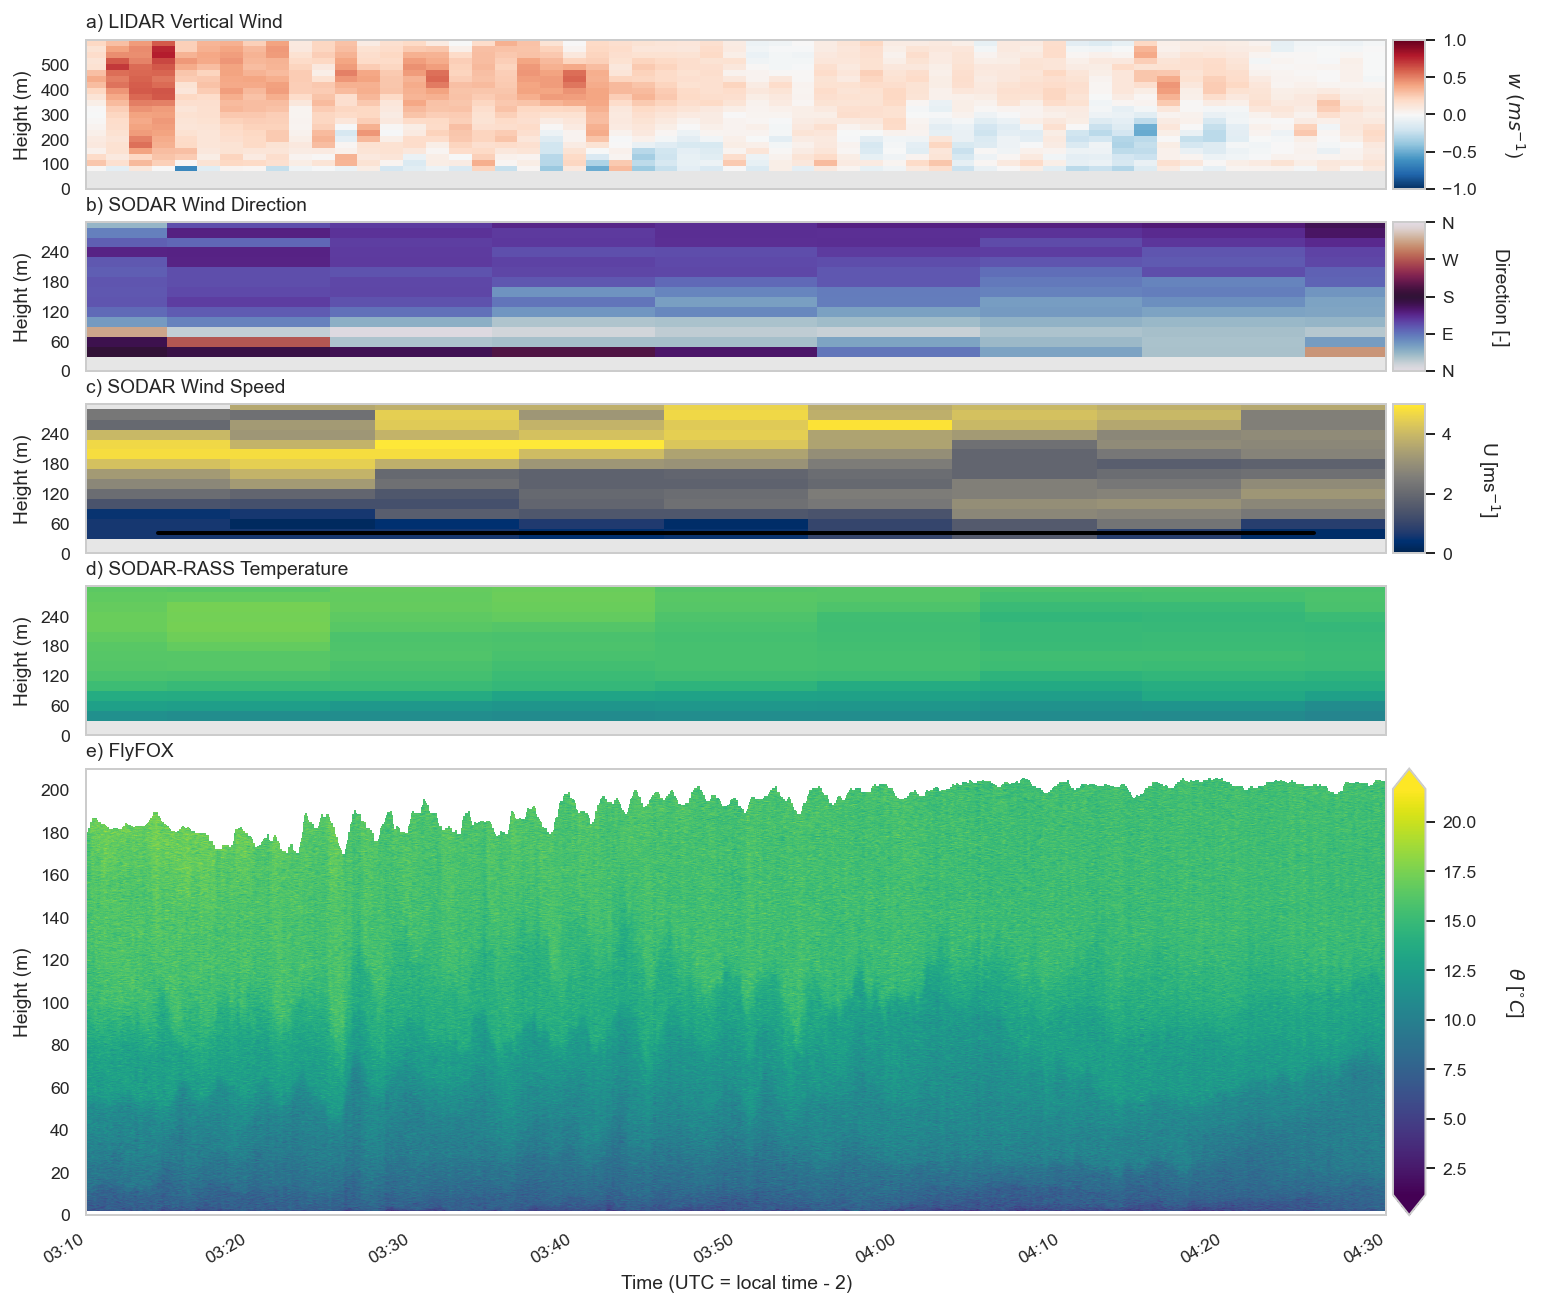

In [21]:
sns.set_context('paper')
# Prep the figure
fig = plt.figure(figsize=(12, 12))

heights = [1, 1, 1, 1, 3]

widths = [1, 0.025]
nrows = 5
# nrows = 7
ncols = 2
spec = fig.add_gridspec(ncols=ncols, nrows=nrows,
                        width_ratios=widths,
                        height_ratios=heights,
                        wspace=0.01, hspace=0.16)
ax_maps = []
for row in range(nrows):
    ax_maps.append(fig.add_subplot(spec[row, 0]))
ax_cbar_lidar = fig.add_subplot(spec[0, 1])
ax_cbar_flyfox = fig.add_subplot(spec[4, 1])
ax_cbar_sodar_dir = fig.add_subplot(spec[1, 1])
ax_cbar_sodar_sp = fig.add_subplot(spec[2, 1])
# ax_cbar_tower_u = fig.add_subplot(spec[6, 1])

# Prep the data
ft = 'LOVE_Flyfox_190718'
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:30')
vmin = ff_18.theta_v.min() - 273.13
vmax = ff_18.theta_v.max() - 273.13

# Prepare the SODAR-RASS data
t1 = tflight1.floor('10min')
t2 = tflight2.ceil('10min')
fl_sodar = sodar.sel(time=slice(t1, t2))
sodar_z_max = 300
sodar_z_min = 0
sodar_z_ticks = np.arange(sodar_z_min, sodar_z_max, 60)

# Prepare the LIDAR data
fl_lidar = lidar.sel(time=slice(t1, t2))
lidar_z_max = 600
lidar_z_min = 0
lidar_z_ticks = np.arange(lidar_z_min, lidar_z_max, 100)

# LIDAR
ax = ax_maps[0]
ax.set_facecolor('0.9')
color = lidar.mean_w.T.values
im = ax.pcolormesh(
    lidar.time,
    lidar.z,
    color,
    cmap='RdBu_r',
    linewidth=0,
    rasterized=True,
    vmin=-1,
    vmax=1,
    shading='nearest',
)
im.set_edgecolor('face')
ax.set_ylabel('Height (m)')
ax.set_ylim(lidar_z_min, lidar_z_max)
ax.set_yticks(lidar_z_ticks)
ax.set_xlim(pd.Timestamp(tflight1), pd.Timestamp(tflight2))
cbar = fig.colorbar(im, cax=ax_cbar_lidar)
cbar.ax.set_ylabel('$w~ (ms^{-1}$)', rotation=270, labelpad=25)
ax.set_title('a) LIDAR Vertical Wind', loc='left')

# Direction
ax = ax_maps[1]
ax.set_facecolor('0.9')
color = fl_sodar.wind_direction.sel(z=slice(sodar_z_min, sodar_z_max))
im = ax.pcolormesh(
    color.time,
    color.z,
    color.T,
    cmap='twilight',
    linewidth=0,
    rasterized=True,
    vmin=0, 
    vmax=360,
    shading='nearest',
)
im.set_edgecolor('face')
ax.set_ylabel('Height (m)')
ax.set_ylim(sodar_z_min, sodar_z_max)
ax.set_yticks(sodar_z_ticks)
ax.set_xlim(tflight1, tflight2)
cbar = fig.colorbar(im, cax=ax_cbar_sodar_dir)
cbar.ax.set_ylabel('Direction [-]', rotation=270, labelpad=25)
cbar.set_ticks([0, 90, 180, 270, 360])
cbar.ax.set_yticklabels(['N', 'E', 'S', 'W', 'N'])
ax.set_title('b) SODAR Wind Direction', loc='left')

# Speed
ax = ax_maps[2]
ax.set_facecolor('0.9')
color = fl_sodar.wind_speed.sel(z=slice(sodar_z_min, sodar_z_max))
color = color.where(color < 10)
im = ax.pcolormesh(
    color.time,
    color.z,
    color.T.values,
    cmap='cividis',
    vmin=0,
    vmax=5,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.plot([t1, t2], [40, 40], 'k', linewidth=2)
ax.set_ylabel('Height (m)')
ax.set_ylim(sodar_z_min, sodar_z_max)
ax.set_yticks(sodar_z_ticks)
cbar = fig.colorbar(im, cax=ax_cbar_sodar_sp)
cbar.ax.set_ylabel('U [ms$^{-1}$]', rotation=270, labelpad=25)
ax.set_title('c) SODAR Wind Speed', loc='left')

# Plot the SODAR temperatures
ax = ax_maps[3]
ax.set_facecolor('0.9')
color = fl_sodar.temperature.sel(z=slice(sodar_z_min, sodar_z_max))
color = color.where(color > 0)
ax.pcolormesh(
    color.time,
    color.z,
    color.T.values,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.set_ylabel('Height (m)')
ax.set_ylim(sodar_z_min, sodar_z_max)
ax.set_yticks(sodar_z_ticks)
ax.set_xlim(tflight1, tflight2)
ax.set_title('d) SODAR-RASS Temperature', loc='left')

# Plot the FlyFOX data
ax = ax_maps[4]

im = ax.pcolormesh(
    ff_18.time,
    ff_18.z,
    ff_18.theta_v.rolling(time=3, center=True).mean().T - 273.13,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.set_ylabel('Height (m)')
ax.set_xlabel('Time (UTC = local time - 2)')
fig.autofmt_xdate()
ax.set_ylim(0, 210)
ax.set_yticks(np.arange(0, 220, 20))
ax.set_title('e) FlyFOX', loc='left')
ax.set_xlim(tflight1, tflight2)
plt.colorbar(im, cax=ax_cbar_flyfox, extend='both')
ax_cbar_flyfox.set_ylabel(r'$\theta$ [$^{\circ}C$]', rotation=270, labelpad=25)

ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

os.chdir(dir_print)
fig.savefig('LOVE-Flyfox-190718_column-example.morning-only.v3.pdf', dpi=300, bbox_inches='tight')
fig.savefig('LOVE-Flyfox-190718-column-example.morning-only.v3.png', dpi=300, bbox_inches='tight')

# Visualize data from the surface DTS and CSAT

## First, prepare the surface data

In [22]:
NE_names = {
    'ss': ['OR_NE1', 'OR_NE2'],
    'p1': ['IR_NE1', 'IR_NE2'],
}

SW_names = {
    'ss': ['OR_SW1', 'OR_SW2'],
    'p1': ['IR_SW1', 'IR_SW2'],
}

# -----------------------------------------------------------------
# Inner rim
inner = ds_p1

# Stictch together two segments to create a super segment
inner_sw = inner.where(
    (inner.p1==SW_names['p1'][0]) | (inner.p1==SW_names['p1'][1]),
    drop=True
)
inner_ne = inner.where(
    (inner.p1==NE_names['p1'][0]) | (inner.p1==NE_names['p1'][1]),
    drop=True
)

# Handle the overlapping indices from stitching together
inner_ne = pyfocs.xr_helper.xr_unique_index(inner_ne.swap_dims({'xyz': 'x'}), 'x')
inner_ne = inner_ne.swap_dims({'x': 'p1'})
inner_ne.coords['p1'] = ['IR_NE'] * inner_ne.p1.size
inner_sw = pyfocs.xr_helper.xr_unique_index(inner_sw.swap_dims({'xyz': 'x'}), 'x')
inner_sw = inner_sw.swap_dims({'x': 'p1'})
inner_sw.coords['p1'] = ['IR_SW'] * inner_sw.p1.size

inner_nw = inner.swap_dims({'xyz': 'p1'}).loc[{'p1': 'IR_NW'}]
inner_se = inner.swap_dims({'xyz': 'p1'}).loc[{'p1': 'IR_SE'}]
inner = xr.concat([inner_se, inner_nw, inner_sw, inner_ne], dim='p1')
inner = inner.rename({'p1': 'unheated'})

# -----------------------------------------------------------------
# Outer rim - unheated
outer = ds_ss_cold

# Stictch together two segments to create a super segment
outer_sw = outer.where(
    (outer.unheated==SW_names['ss'][0]) | (outer.unheated==SW_names['ss'][1]),
    drop=True
)
outer_ne = outer.where(
    (outer.unheated==NE_names['ss'][0]) | (outer.unheated==NE_names['ss'][1]),
    drop=True
)

# Handle the overlapping indices from stitching together
outer_ne = pyfocs.xr_helper.xr_unique_index(outer_ne.swap_dims({'xyz': 'x'}), 'x')
outer_ne = outer_ne.swap_dims({'x': 'unheated'})
outer_ne.coords['unheated'] = ['OR_NE'] * outer_ne.unheated.size
outer_sw = pyfocs.xr_helper.xr_unique_index(outer_sw.swap_dims({'xyz': 'x'}), 'x')
outer_sw = outer_sw.swap_dims({'x': 'unheated'})
outer_sw.coords['unheated'] = ['OR_SW'] * outer_sw.unheated.size

outer_nw = outer.swap_dims({'xyz': 'unheated'}).loc[{'unheated': 'OR_NW'}]
outer_se = outer.swap_dims({'xyz': 'unheated'}).loc[{'unheated': 'OR_SE'}]
outer = xr.concat([outer_se, outer_nw, outer_ne, outer_sw], dim='unheated')

In [23]:
# Grab just the NE segment during the plotted period and 
# do a bit of time averaging to make it prettier

tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:10')
tslice = slice(tflight1, tflight2)

section_name = 'IR_NE'
section_name = 'IR_SW'
ds_inner = inner.sel(unheated=section_name).swap_dims({'unheated': 'y'}).sel(time=tslice)
ds_inner = ds_inner.rolling(time=5, center=True).mean()
ds_inner = ds_inner.rolling(y=10, center=True).mean()

section_name = 'OR_NE'
section_name = 'OR_SW'
ds_outer = outer.sel(unheated=section_name).swap_dims({'unheated': 'y'}).sel(time=tslice)
ds_outer = ds_outer.rolling(time=5, center=True).mean()
ds_outer = ds_outer.rolling(y=10, center=True).mean()

In [24]:
# -----------------------------------------------------------------
# Outer rim - wind speed

section_names = ['OR_NE1', 'OR_NE2']
section_names = ['OR_SW1', 'OR_SW2']

logic = [wind_speed_ew.unheated == l for l in section_names]
logic = xr.concat(logic, dim='locations').any(dim='locations')
ds_outer_wind = wind_speed_ew.where(logic, drop=True)
ds_outer_wind = ds_outer_wind.sel(time=tslice)

ds_outer_wind = pyfocs.xr_helper.xr_unique_index(ds_outer_wind.swap_dims({'xyz': 'y'}), 'y')
ds_outer_wind = ds_outer_wind.sortby('y')
ds_outer_wind = ds_outer_wind.rolling(time=5, center=True).mean()
ds_outer_wind = ds_outer_wind.rolling(y=10, center=True).mean()

In [25]:
# Smooth the tower data so it looks prettier
ds_tower_cold_smooth = ds_tower_cold.sel(time=slice(tflight1, tflight2)).swap_dims({'xyz': 'z'})
ds_tower_cold_smooth = ds_tower_cold_smooth.rolling(time=10, center=True).mean()
ds_tower_cold_smooth = ds_tower_cold_smooth.rolling(z=8, center=True).mean()

ds_tower_wind_smooth = tower_wind_speed.sel(time=slice(tflight1, tflight2)).swap_dims({'xyz': 'z'})
ds_tower_wind_smooth = ds_tower_wind_smooth.rolling(time=5, center=True).mean()
ds_tower_wind_smooth = ds_tower_wind_smooth.rolling(z=8, center=True).mean()

## Helper function for creating the inset maps

In [26]:
def inset_plotter(ds_highlight, others, axins):
    
    for ds_other in others:
        axins.scatter(
            ds_other.x.values,
            ds_other.y.values,
            0.5,
            color='0.8',
            )

    axins.scatter(
        ds_highlight.x.values,
        ds_highlight.y.values,
        0.5,
        color='k'
    )
    
    axins.grid(False)
    axins.set_xticks([])
    axins.set_yticks([])

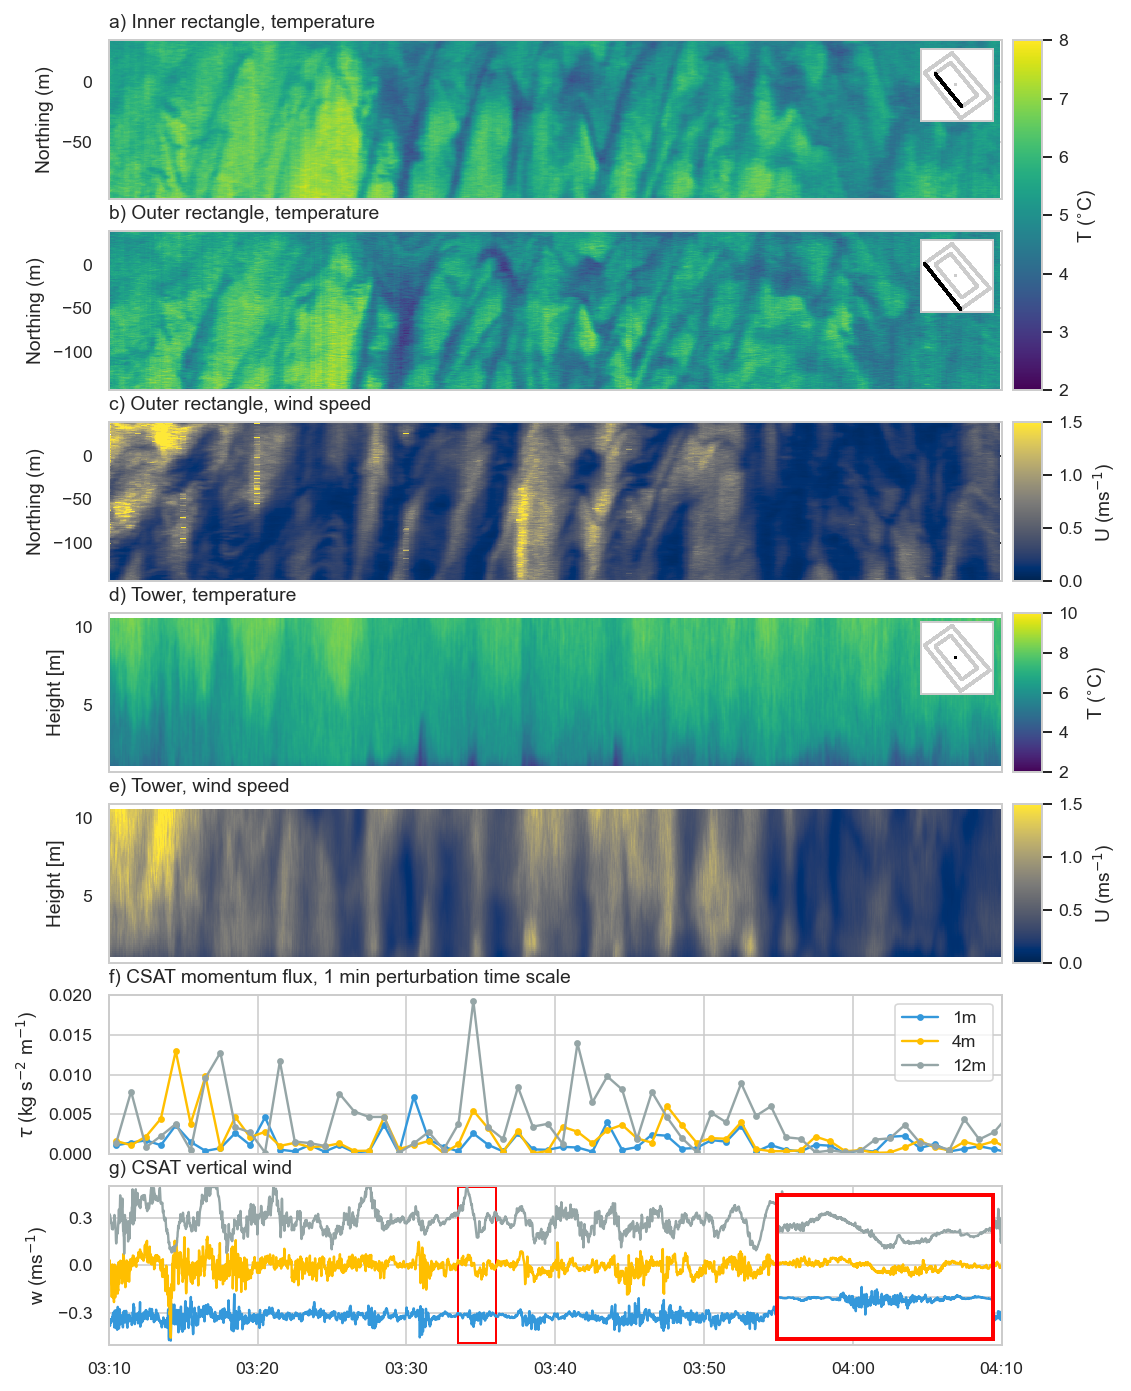

In [27]:
tflight1 =  pd.Timestamp(flight_times[ft][0])
tflight2 = pd.Timestamp('2019-07-18 04:10')
tslice = slice(tflight1, tflight2)

fig, axes = plt.subplots(7, 1, figsize=(8, 12), sharex=True)
vmin = 2
vmax = 8

# Inner rectangle
ax = axes[0]
ax.set_title('a) Inner rectangle, temperature', loc='left')
im = ax.pcolormesh(
    ds_inner.time,
    ds_inner.y.values,
    ds_inner.cal_temp.T, 
    cmap='viridis',
    shading='nearest',
    vmin=vmin,
    vmax=vmax,
)
ax.grid()
ax.set_ylabel('Northing (m)')
pos_ax_a = ax.get_position()

# Inset map
axins = inset_axes(
    ax,
    width=0.5,
    height=0.5,
    loc='upper right'
)
inset_plotter(ds_inner, [ds_p1, ds_ss_cold, ds_tower_cold], axins)

# Outer rectangle
ax = axes[1]
ax.set_title('b) Outer rectangle, temperature', loc='left')
im = ax.pcolormesh(
    ds_outer.time,
    ds_outer.y.values,
    ds_outer.cal_temp.T, 
    cmap='viridis',
    shading='nearest',
    vmin=vmin,
    vmax=vmax,
)
ax.grid()
ax.set_ylabel('Northing (m)')
pos_ax_b = ax.get_position()

# Inset map
axins = inset_axes(
    ax,
    width=0.5,
    height=0.5,
    loc='upper right'
)
inset_plotter(ds_outer, [ds_p1, ds_ss_cold, ds_tower_cold], axins)

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_b.y0, 0.025, pos_ax_a.y1 - pos_ax_b.y0]))
plt.colorbar(im,
    cax=axcbar,
    orientation="vertical",
    label='T ($^{\circ}$C)',
)

# Outer rectangle FODS wind speed
ax = axes[2]
ax.set_title('c) Outer rectangle, wind speed', loc='left')
im_u = ax.pcolormesh(
    ds_outer_wind.time,
    ds_outer_wind.y.values,
    ds_outer_wind, 
    vmin=0,
    vmax=1.5,
    cmap='cividis',
    shading='nearest',
)
ax.grid()
ax.set_ylabel('Northing (m)')
ax.grid(True, which='major', axis='both', linestyle='-', color='k')
pos_ax_c = ax.get_position()

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_c.y0, 0.025, pos_ax_c.y1 - pos_ax_c.y0]))
plt.colorbar(im_u,
    cax=axcbar,
    orientation="vertical",
    label='U (ms$^{-1}$)',
)

# Plot the smoothed DTS tower data
ax = axes[3]
im = ax.pcolormesh(
    ds_tower_cold_smooth.time,
    ds_tower_cold_smooth.z,
    (ds_tower_cold_smooth.cal_temp + (ds_tower_cold_smooth.z) * 0.01).T.values,
    cmap='viridis',
    vmin=vmin,
    vmax=10,
    linewidth=0,
    rasterized=True,
    shading='nearest',
)
ax.set_xlim(tflight1, tflight2)
ax.set_ylim(ds_tower_cold_smooth.z.min(), ds_tower_cold_smooth.z.max())
ax.set_ylabel('Height [m]')
ax.set_title('d) Tower, temperature', loc='left')
pos_ax_d = ax.get_position()

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_d.y0, 0.025, pos_ax_d.y1 - pos_ax_d.y0]))
plt.colorbar(im,
    cax=axcbar,
    orientation="vertical",
    label='T ($^{\circ}$C)',
)
# Inset map
axins = inset_axes(
    ax,
    width=0.5,
    height=0.5,
    loc='upper right'
)
inset_plotter(ds_tower_cold, [ds_p1, ds_ss_cold, ds_tower_cold], axins)

# Plot the FODS of wind speed
ax = axes[4]
im = ax.pcolormesh(
    ds_tower_wind_smooth.time,
    ds_tower_wind_smooth.z,
    ds_tower_wind_smooth.T.values,
    cmap='cividis',
    vmin=0.,
    vmax=1.5,
    linewidth=0,
    rasterized=True,
    shading='nearest'
)
ax.set_xlim(tflight1, tflight2)
ax.set_ylim(ds_tower_wind_smooth.z.min(), ds_tower_wind_smooth.z.max())
ax.set_ylabel('Height [m]')
ax.set_title('e) Tower, wind speed', loc='left')
pos_ax_e = ax.get_position()

# Colorbar
axcbar = fig.add_axes(
    np.array([0.91, pos_ax_e.y0, 0.025, pos_ax_e.y1 - pos_ax_e.y0]))
plt.colorbar(im_u,
    cax=axcbar,
    orientation="vertical",
    label='U (ms$^{-1}$)',
)

# CSAT momentum flux
ax = axes[5]
for n in csat_names:
    ax.plot(
        ds_csat.sel(names=n).time + pd.Timedelta(seconds=30),
        ds_csat.sel(names=n)['tau'],
        marker='.',
        label=n,
    )
ax.set_ylabel(r'$\tau$ (kg s$^{-2}$ m$^{-1}$)')
ax.set_xticks([])
ax.set_ylim(0, 0.02)
ax.set_title('f) CSAT momentum flux, 1 min perturbation time scale', loc='left')
ax.legend()
ax.set_xlim(tflight1, tflight2)

# CSAT vertical wind (at 1Hz)
ax = axes[6]
for n_lvl, lvl in enumerate(['S1m_Uz', 'S4m_Uz', 'S12m_Uz']):
    ax.plot(csat_ts_1s.time, csat_ts_1s[lvl] - 0.3 + 0.3 * n_lvl)
ax.set_yticks([-0.3, 0., 0.3], minor=False)
ax.yaxis.grid(True, which='major')
ax.set_ylabel('w (ms$^{-1}$)')
ax.set_title('g) CSAT vertical wind', loc='left')
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(tflight1, tflight2)

axins_xlims = [
    pd.Timestamp('2019-07-18 03:33:30'),
    pd.Timestamp('2019-07-18 03:36')
]
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

# Create a Rectangle patch
rect = patches.Rectangle(
    (axins_xlims[0], -0.49),
    axins_xlims[1] - axins_xlims[0], 0.98,
    linewidth=1,
    edgecolor='r',
    facecolor='none'
)
# Add the patch to the Axes
ax.add_patch(rect)

# Inset time series at 20Hz
axins = inset_axes(
    ax,
    width=1.5,
    height=1,
    loc='upper right'
)
for n_lvl, lvl in enumerate(['S1m_Uz', 'S4m_Uz', 'S12m_Uz']):
    axins.plot(csat_ts.time, csat_ts[lvl] - 0.3 + 0.3 * n_lvl)
axins.set_xlim(axins_xlims)
axins.set_yticks([-0.3, 0., 0.3], minor=False)
axins.set_xticklabels([])
axins.set_xticks([])
axins.yaxis.grid(True, which='major')
axins.set_yticklabels([])
axins.spines["top"].set_color("red")
axins.spines["top"].set_linewidth(2)
axins.spines["left"].set_color("red")
axins.spines["left"].set_linewidth(2)
axins.spines["right"].set_color("red")
axins.spines["right"].set_linewidth(2)
axins.spines["bottom"].set_color("red")
axins.spines["bottom"].set_linewidth(2)

os.chdir(dir_print)
fig.savefig('LOVE-Flyfox-190718_surface-example.morning-only.v1.pdf', dpi=300, bbox_inches='tight')
fig.savefig('LOVE-Flyfox-190718_surface-example.morning-only.v1.png', dpi=300, bbox_inches='tight')
fig.savefig('LOVE-Flyfox-190718_surface-example.morning-only.v1.jpg', dpi=300, bbox_inches='tight')